In [1]:
import numpy as np
import pandas as pd
import os

symsim_data_path = (
    "/lustre/groups/ml01/workspace/weixu.wang/reference.mapping.DE/data/symsim_nevf30.n_de_evf_18.sigma_0.rep_1/DE"
)
x_obs_all = pd.read_csv(
    os.path.join(symsim_data_path, "DE_med.obsv.3.csv"), index_col=0
).T
batch_info = (
    pd.read_csv(os.path.join(symsim_data_path, "DE_med.batchid.csv"), index_col=0) - 1
)
metadata = pd.read_csv(
    os.path.join(symsim_data_path, "DE_med.cell_meta.csv"), index_col=0
)

x_obs = x_obs_all

# OLD
select_gene = np.arange(x_obs_all.values.shape[1])
# non_null_genes = x_obs_all.sum(0) > 0
# _lfc_info = pd.read_csv(
#     os.path.join(symsim_data_path, "med_theoreticalFC.csv"), index_col=0
# )
# bimod_select = (_lfc_info["23"].abs() <= 0.2) | (_lfc_info["23"].abs() >= 1.5)

# NEW
label_a = 1
label_b = 2

k_on = pd.read_csv(os.path.join(symsim_data_path, "DE_med.kon_mat.csv"))
k_off = pd.read_csv(os.path.join(symsim_data_path, "DE_med.koff_mat.csv"))
s_mat = pd.read_csv(os.path.join(symsim_data_path, "DE_med.s_mat.csv"))

k_on = k_on.values.T
k_off = k_off.values.T
s_mat = s_mat.values.T

# labels = dataset.labels.squeeze()
labels = metadata["pop"].values - 1
where_a = np.where(labels == 1)[0]  # [:1000]
where_b = np.where(labels == 2)[0]  # [:1000]
print(label_a, label_b, where_a.shape, where_b.shape)
means_a = s_mat[where_a] * k_on[where_a] / (k_on[where_a] + k_off[where_a])
means_b = s_mat[where_b] * k_on[where_b] / (k_on[where_b] + k_off[where_b])
lfc_dist_gt = (np.log2(means_a) - np.log2(means_b))[:, select_gene]
lfc_gt = lfc_dist_gt.mean(0)
lfc_gt_alt = np.log2(means_a.mean(0)) - np.log2(means_b.mean(0))


select_gene = np.arange(x_obs_all.values.shape[1])
non_null_genes = x_obs_all.sum(0) > 0
bimod_select = (np.abs(lfc_gt) <= 0.2) | (np.abs(lfc_gt) >= 1.0)

select_gene = non_null_genes * bimod_select
# x_obs_all = x_obs_all.loc[:, non_null_genes]

x_obs = x_obs_all.loc[:, select_gene]
true_ = pd.read_csv(
    os.path.join(symsim_data_path, "DE_med.true.csv"), index_col=0
).T.loc[:, select_gene]
lfc_info = pd.read_csv(
    os.path.join(symsim_data_path, "med_theoreticalFC.csv"), index_col=0
).loc[select_gene, :]
# lfc_info[d_key].values
print("Original data distrib: ", metadata["pop"].groupby(metadata["pop"]).size())

1 2 (2000,) (2000,)
Original data distrib:  pop
1    2000
2    2000
3    2000
4    2000
5    2000
Name: pop, dtype: int64


In [2]:
x_obs.shape

(10000, 396)

In [3]:
batch_info

,x
1,0
2,0
3,0
4,0
5,0
...,...
9996,1
9997,0
9998,0
9999,1


In [4]:
from collections import Counter
dict(Counter(metadata["pop"].values.tolist()))

{1: 2000, 2: 2000, 3: 2000, 4: 2000, 5: 2000}

In [5]:
lfc_info

,24,45,23,12
2,1.316535,0.382303,0.115329,-2.470163
3,0.044400,-0.329002,0.066018,1.336251
5,-0.339799,0.371144,-0.121430,-0.276009
6,-1.368418,-0.019002,-1.309445,0.657169
8,0.383400,-0.754900,0.163949,-0.522600
...,...,...,...,...
993,0.217702,-0.638069,0.163051,-0.211217
994,-0.352452,-0.080771,-0.142328,1.053311
995,-0.013069,0.078293,0.095807,-0.215238
996,-0.982282,0.027855,-1.147552,2.416447


In [6]:
label_a = 1
label_b = 2

d_key = "{}{}".format(label_a + 1, label_b + 1)
print(d_key)

23


In [7]:
import anndata as ad
x_obs.index = metadata["cellid"]
metadata.index = x_obs.index.values
adata = ad.AnnData(X=x_obs, obs=metadata)
adata.obs["batch"] = batch_info["x"].astype(str).values.tolist()
adata.obs["celltype"] = metadata["pop"].astype(str).values.tolist()

/home/icb/weixu.wang/miniconda3/envs/ref_dif_testing/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  after removing the cwd from sys.path.
/home/icb/weixu.wang/miniconda3/envs/ref_dif_testing/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [8]:
import scanpy as sc
#sc.pp.normalize_total(adata, target_sum = 1e4)

In [9]:
import scvi

/home/icb/weixu.wang/miniconda3/envs/ref_dif_testing/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/icb/weixu.wang/miniconda3/envs/ref_dif_testing/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")
Global seed set to 0
/home/icb/weixu.wang/miniconda3/envs/ref_dif_testing/lib/python3.7/site-packages/pytorch_lightning-1.7.7-py3.7.egg/pytorch_lightning/utilities/warnings.py:54: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  "pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6"
/home/icb/weixu.wang/miniconda3/envs/ref_dif_testing/lib/python3.7/si

In [10]:
scvi.model.SCVI.setup_anndata(
    adata,
    batch_key = "batch"
)

In [11]:
model = scvi.model.SCVI(adata,
    n_layers=1,
    encode_covariates=True,
    deeply_inject_covariates=False)
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [04:06<00:00,  1.66it/s, loss=591, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [04:06<00:00,  1.62it/s, loss=591, v_num=1]


In [12]:
surgery_path = '/lustre/groups/ml01/workspace/weixu.wang/reference.mapping.DE/sim/vae_surgery_model'
model.save(surgery_path, overwrite=True)

In [13]:
adata.obsm["X_scVI"] = model.get_latent_representation()
sc.pp.neighbors(adata, use_rep = "X_scVI")
sc.tl.umap(adata)

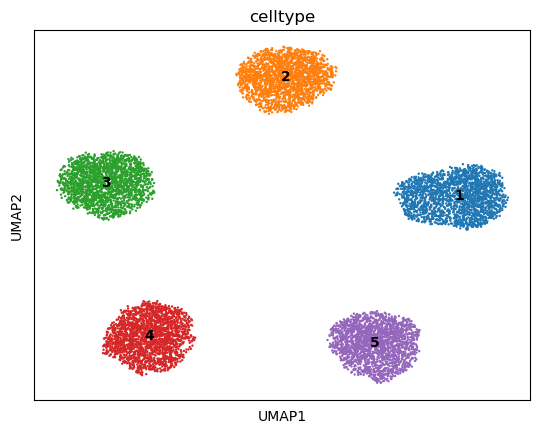

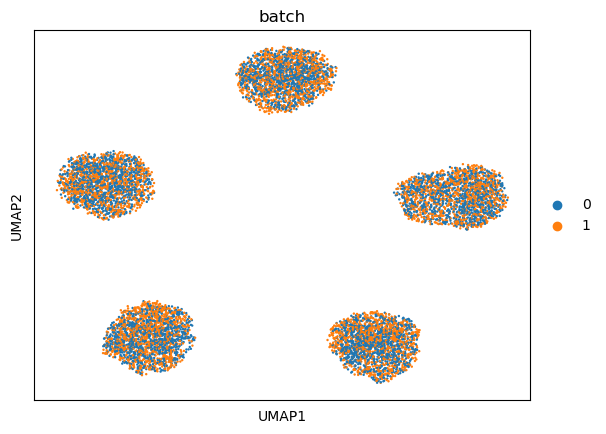

In [14]:
sc.pl.umap(
    adata,
    color = ["celltype"],
    legend_loc = "on data"
    #frameon = False,
)
sc.pl.umap(
    adata,
    color = ["batch"],
    #frameon = False,
)

In [15]:
de_df = model.differential_expression(
    adata = adata,
    groupby = "celltype",
    group1 = "2",
    group2 = "3"
)

DE...: 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


In [16]:
de_df.index = de_df.index.values.astype(int)

In [17]:
de_df.sort_index(inplace=True) 

In [18]:
from scipy import stats

In [19]:
stats.pearsonr(de_df["lfc_median"].values,lfc_info["23"].values)

(0.9435009208704859, 4.2892814433710386e-191)

In [20]:
scvi_error = abs(de_df["lfc_median"].values - lfc_info["23"].values)

In [21]:
import scarches as sca

In [22]:
target_conditions = ['1']
source_adata = adata[~adata.obs["batch"].isin(target_conditions)].copy()
target_adata = adata[adata.obs["batch"].isin(target_conditions)].copy()

In [23]:
sca.models.SCVI.setup_anndata(source_adata, batch_key="batch")
vae = sca.models.SCVI(
    source_adata,
    n_layers=1,
    encode_covariates=True,
    deeply_inject_covariates=False,
)
vae.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [01:56<00:00,  3.47it/s, loss=464, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:56<00:00,  3.43it/s, loss=464, v_num=1]


In [24]:
surgery_path = '/lustre/groups/ml01/workspace/weixu.wang/reference.mapping.DE/sim/vae_ref_model'
vae.save(surgery_path, overwrite=True)

In [25]:
query_model = sca.models.SCVI.load_query_data(
    target_adata,
    surgery_path,
    freeze_dropout = True,
)
query_model.train()

INFO     File /lustre/groups/ml01/workspace/weixu.wang/reference.mapping.DE/sim/vae_ref_model/model.pt already     
         downloaded                                                                                                


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [01:40<00:00,  3.78it/s, loss=725, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:40<00:00,  3.99it/s, loss=725, v_num=1]


In [26]:
adata.obsm["X_scVI"] = query_model.get_latent_representation(adata = adata)
sc.pp.neighbors(adata, use_rep = "X_scVI")
sc.tl.umap(adata)

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


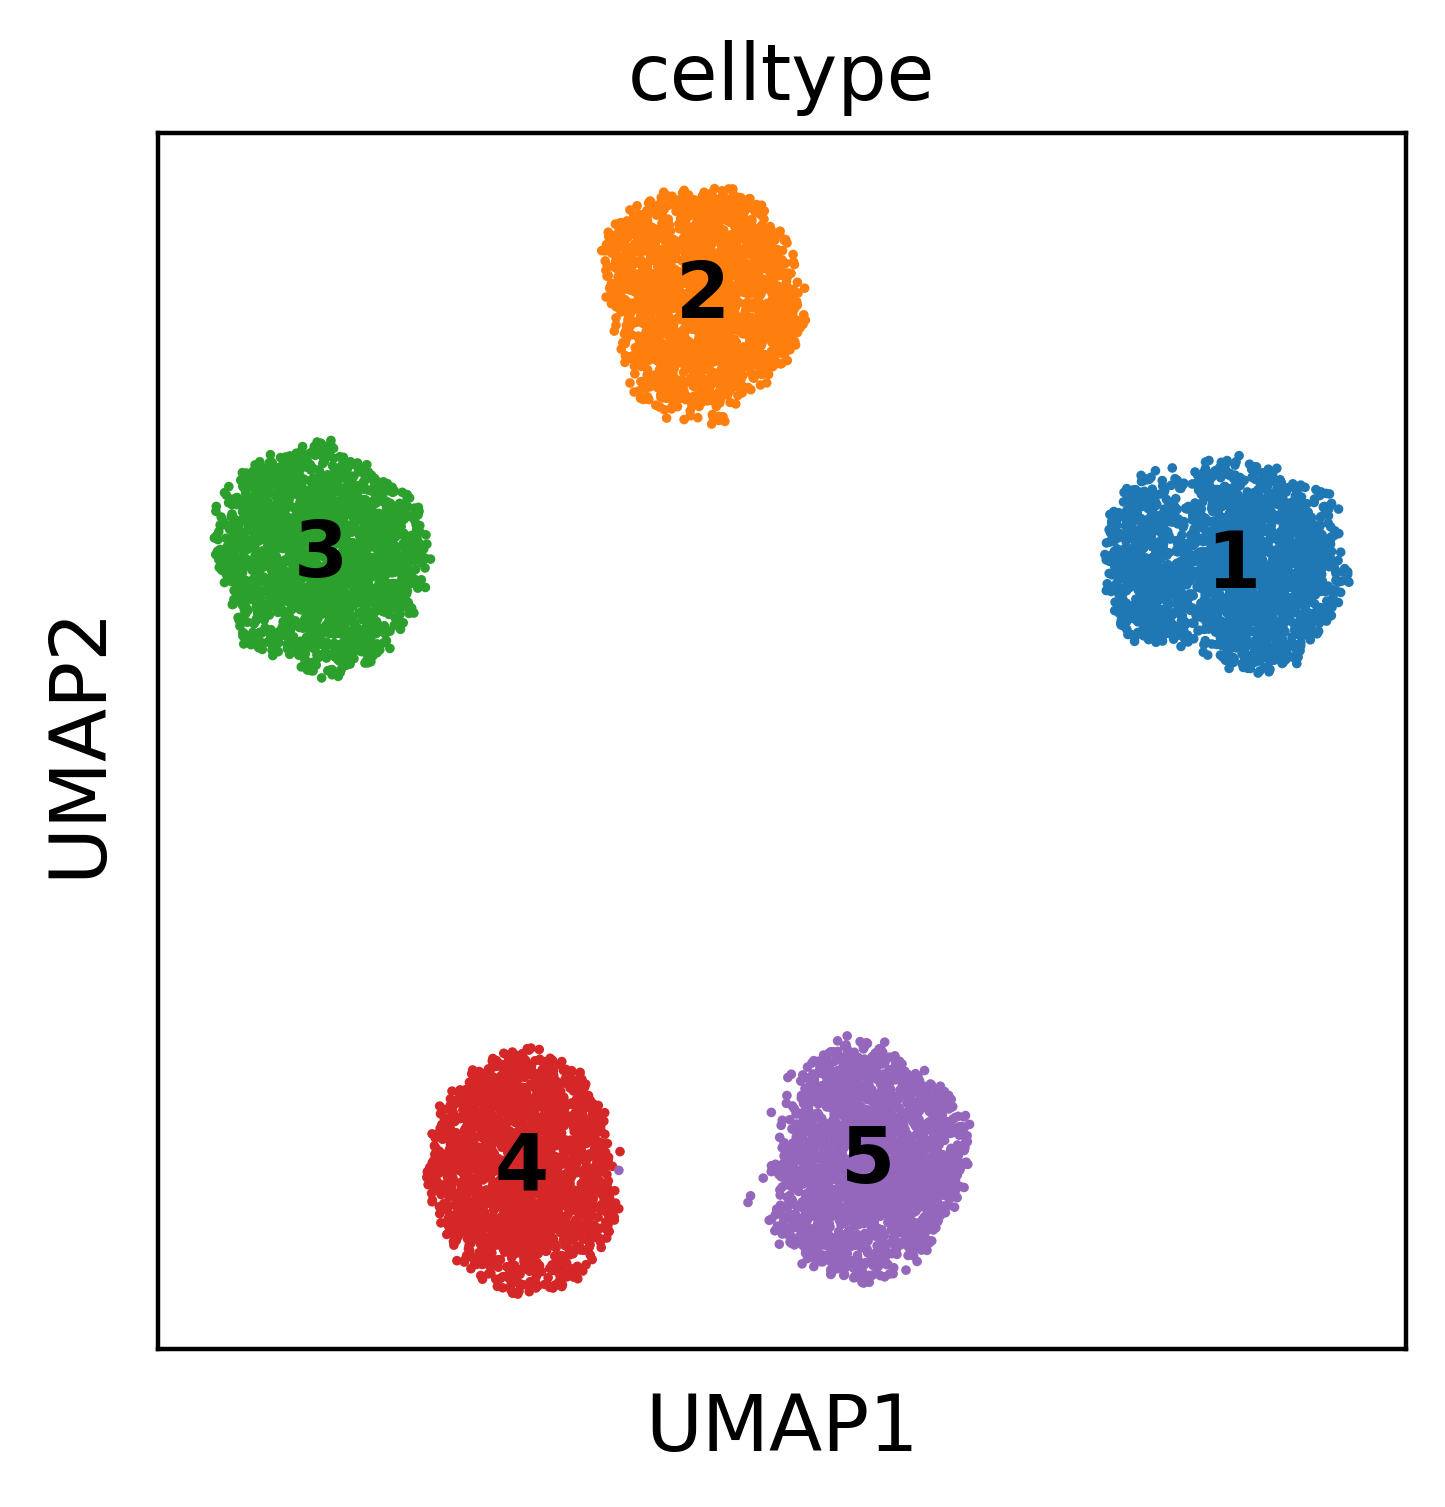

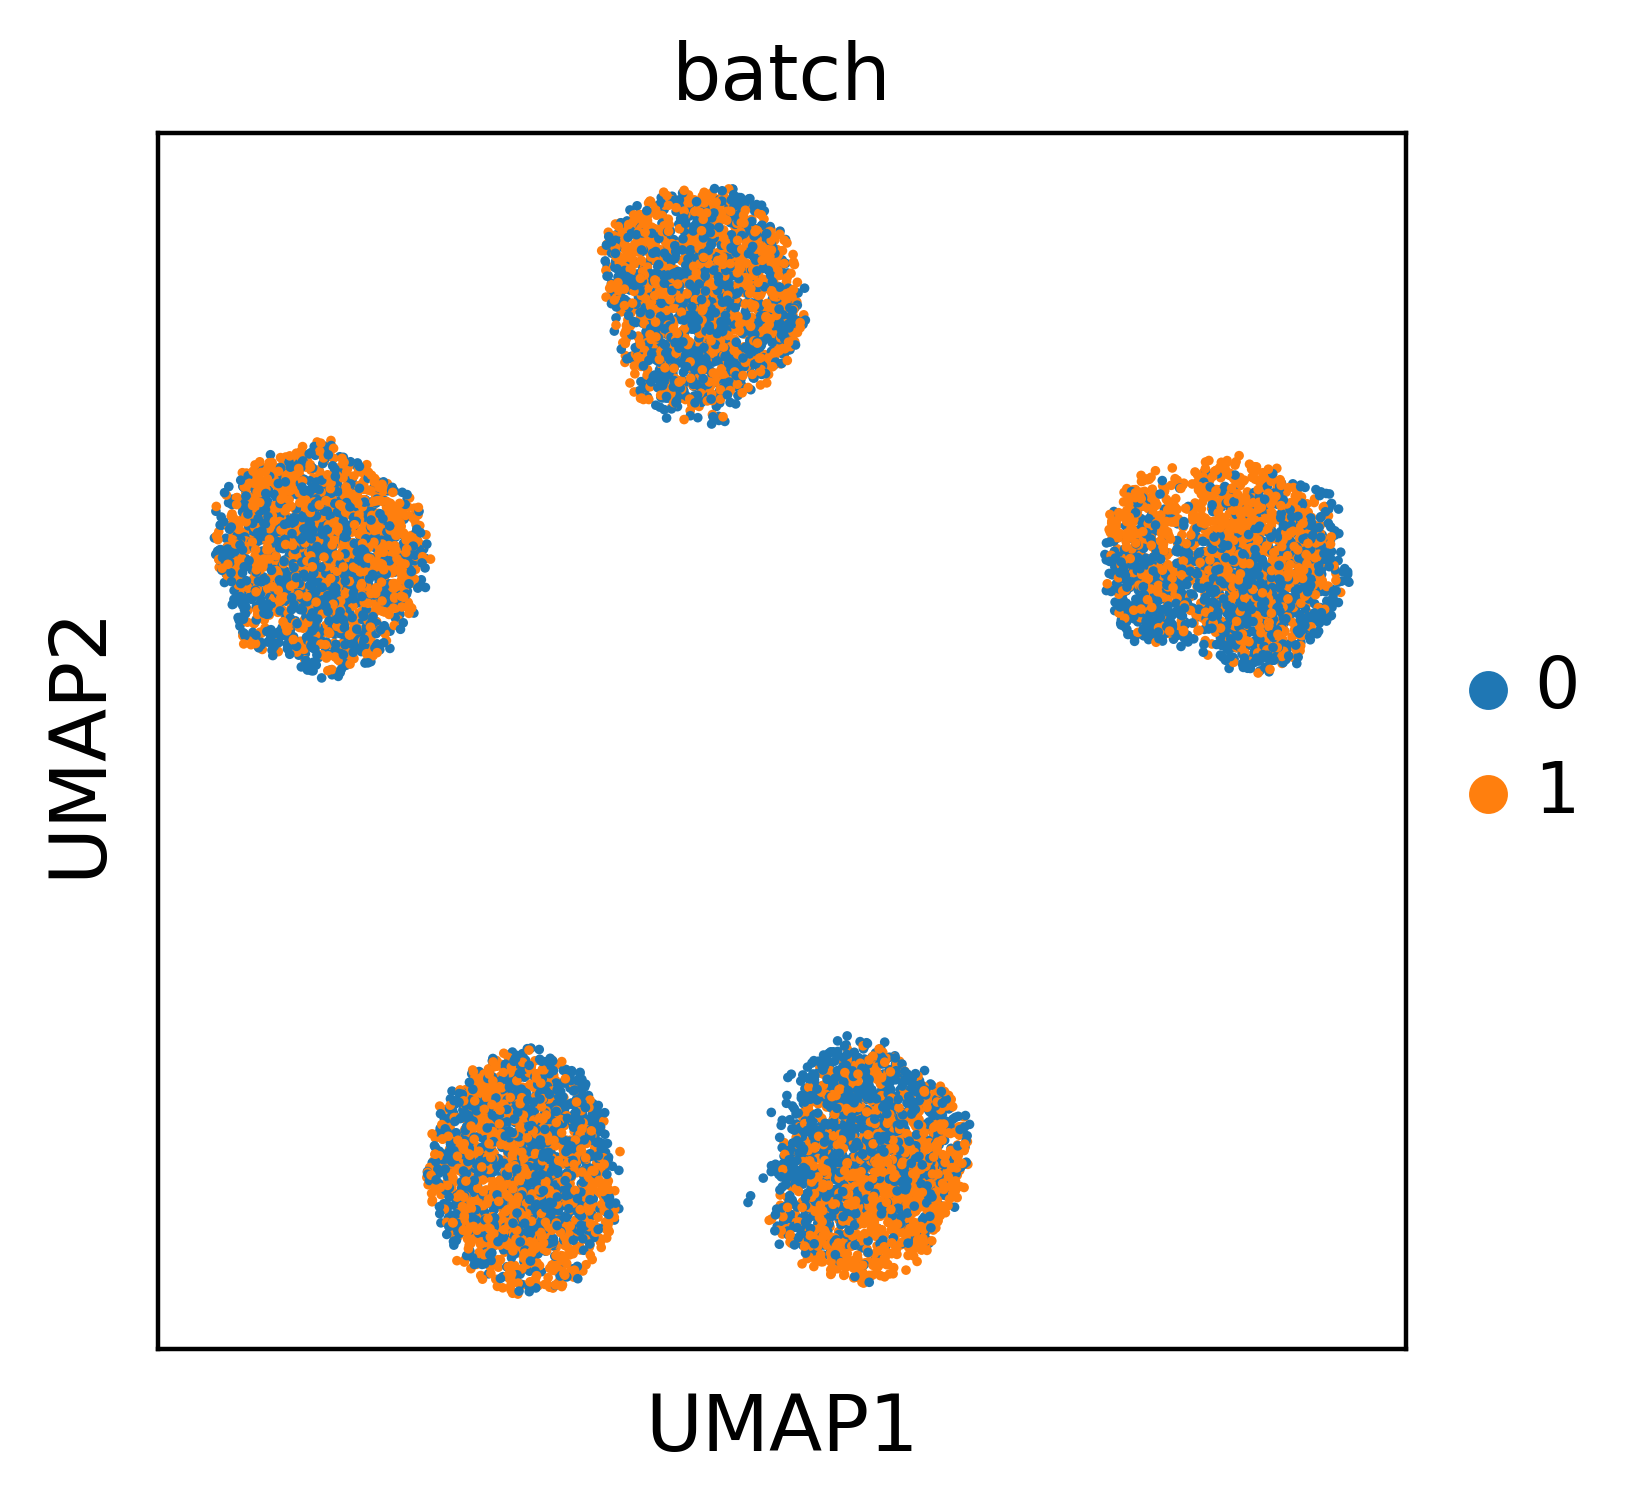

In [27]:
sc.pl.umap(
    adata,
    color = ["celltype"],
    legend_loc = "on data"
    #frameon = False,
)
sc.pl.umap(
    adata,
    color = ["batch"],
    #frameon = False,
)

In [28]:
query_de_df = query_model.differential_expression(
    adata = adata,
    groupby = "celltype",
    group1 = "2",
    group2 = "3"
)

DE...: 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


In [29]:
query_de_df.index = query_de_df.index.values.astype(int)

In [30]:
query_de_df.sort_index(inplace=True) 

In [31]:
stats.pearsonr(query_de_df["lfc_median"].values,lfc_info["23"].values)

(0.7717501912779932, 1.8106792481149938e-79)

In [32]:
scarches_error = abs(query_de_df["lfc_median"].values - lfc_info["23"].values)

In [33]:
scarches_error.mean()

1.12148101965576

In [34]:
scvi_error.mean()

0.9764838957429204

In [35]:
Error = scarches_error.tolist()+scvi_error.tolist()
Class = np.repeat("scarches",len(scarches_error)).tolist()+np.repeat("scvi",len(scvi_error)).tolist()

In [36]:
dat = pd.DataFrame([Class,Error],index = ["Class","Error"]).T

<AxesSubplot:xlabel='Error', ylabel='Class'>

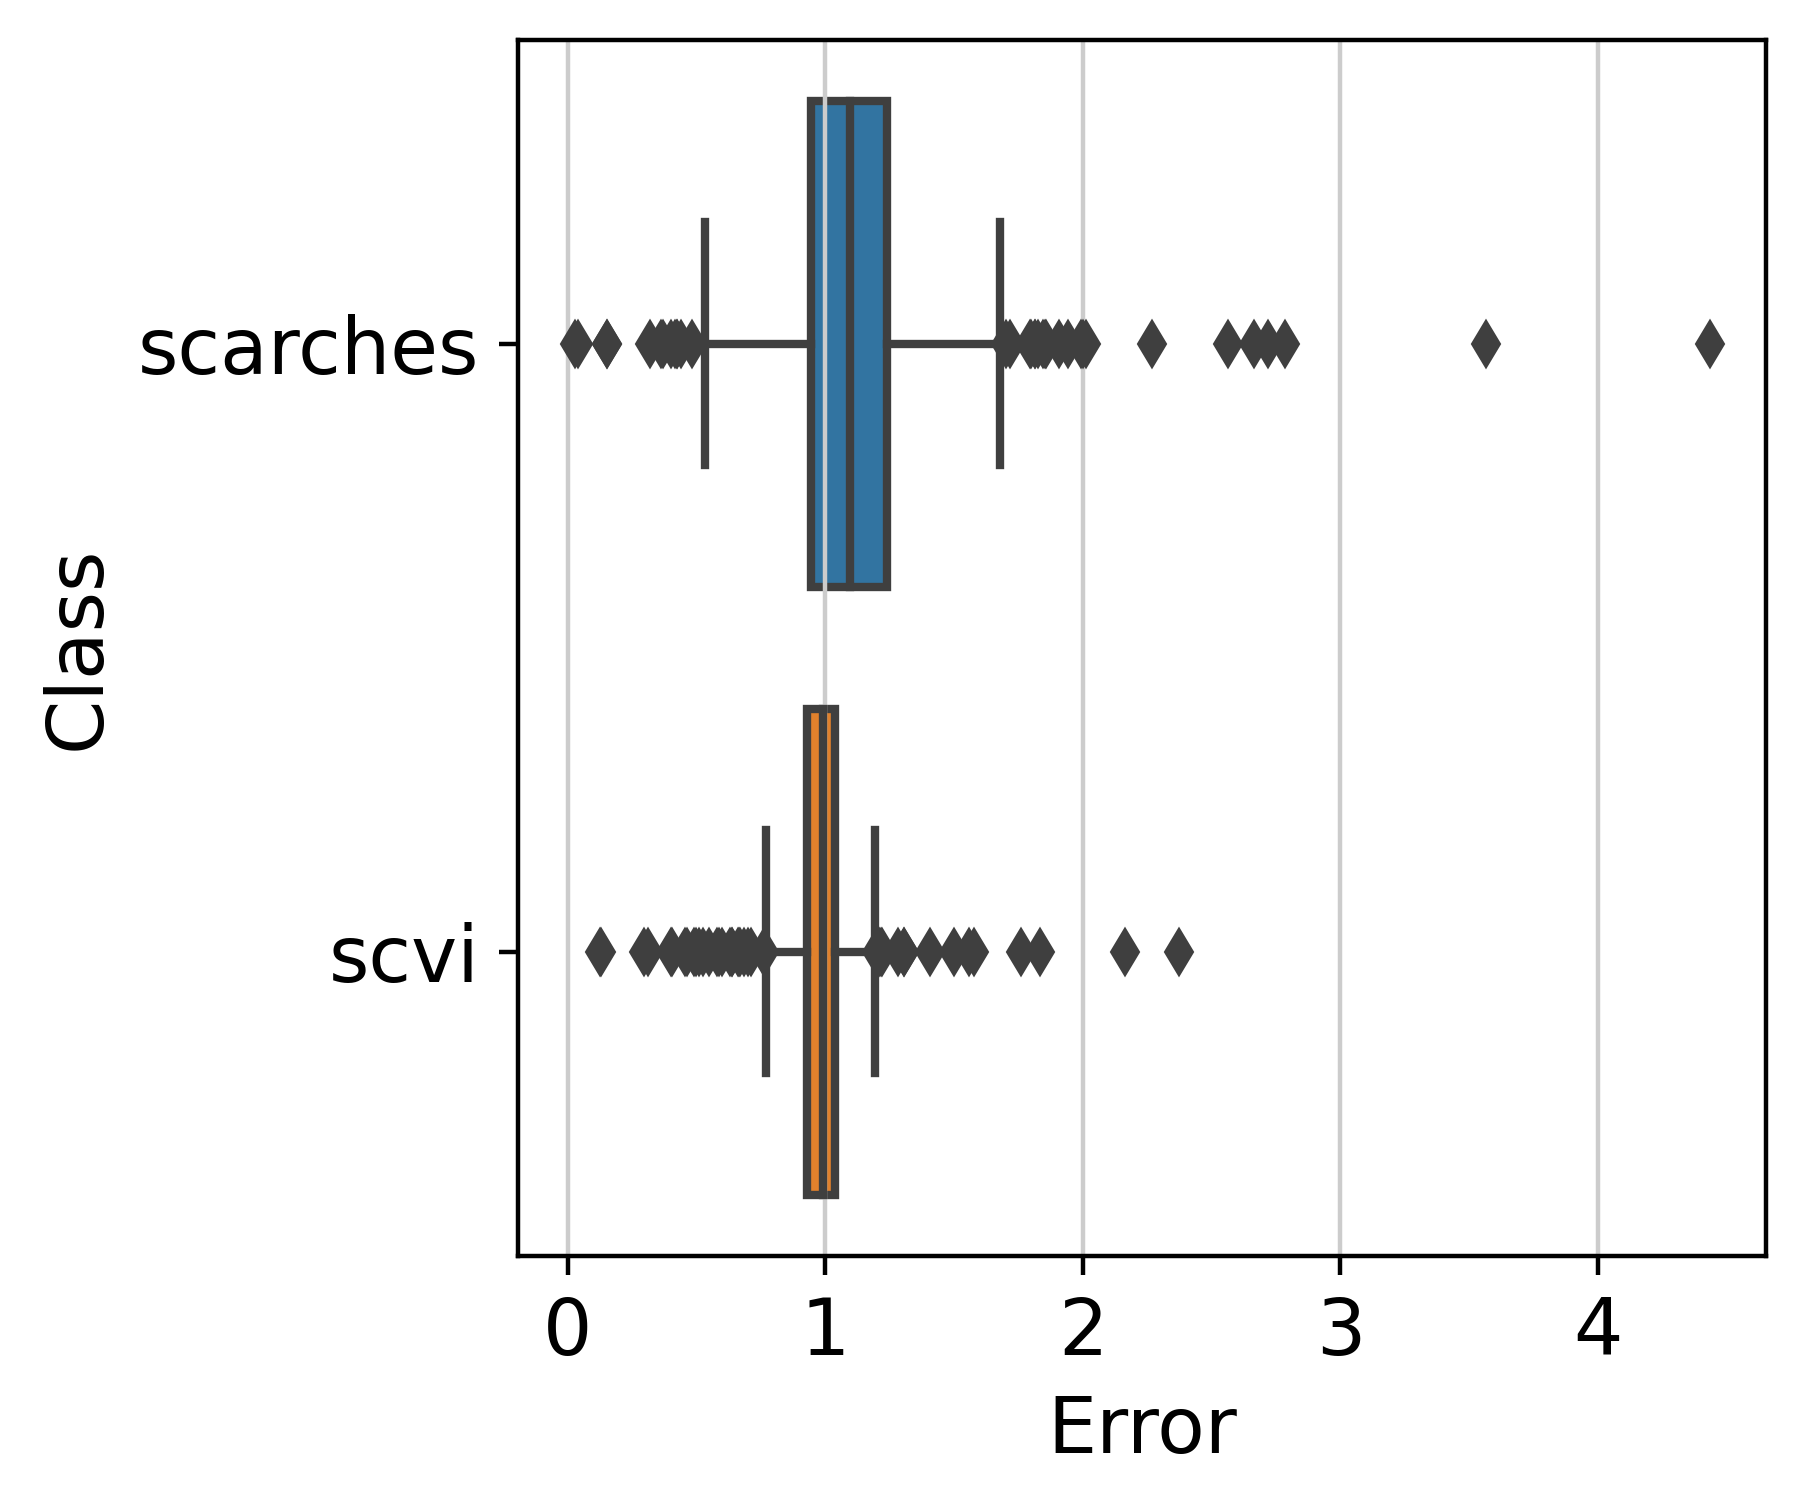

In [37]:
import seaborn as sns
sns.boxplot(data=dat, x="Error", y="Class")

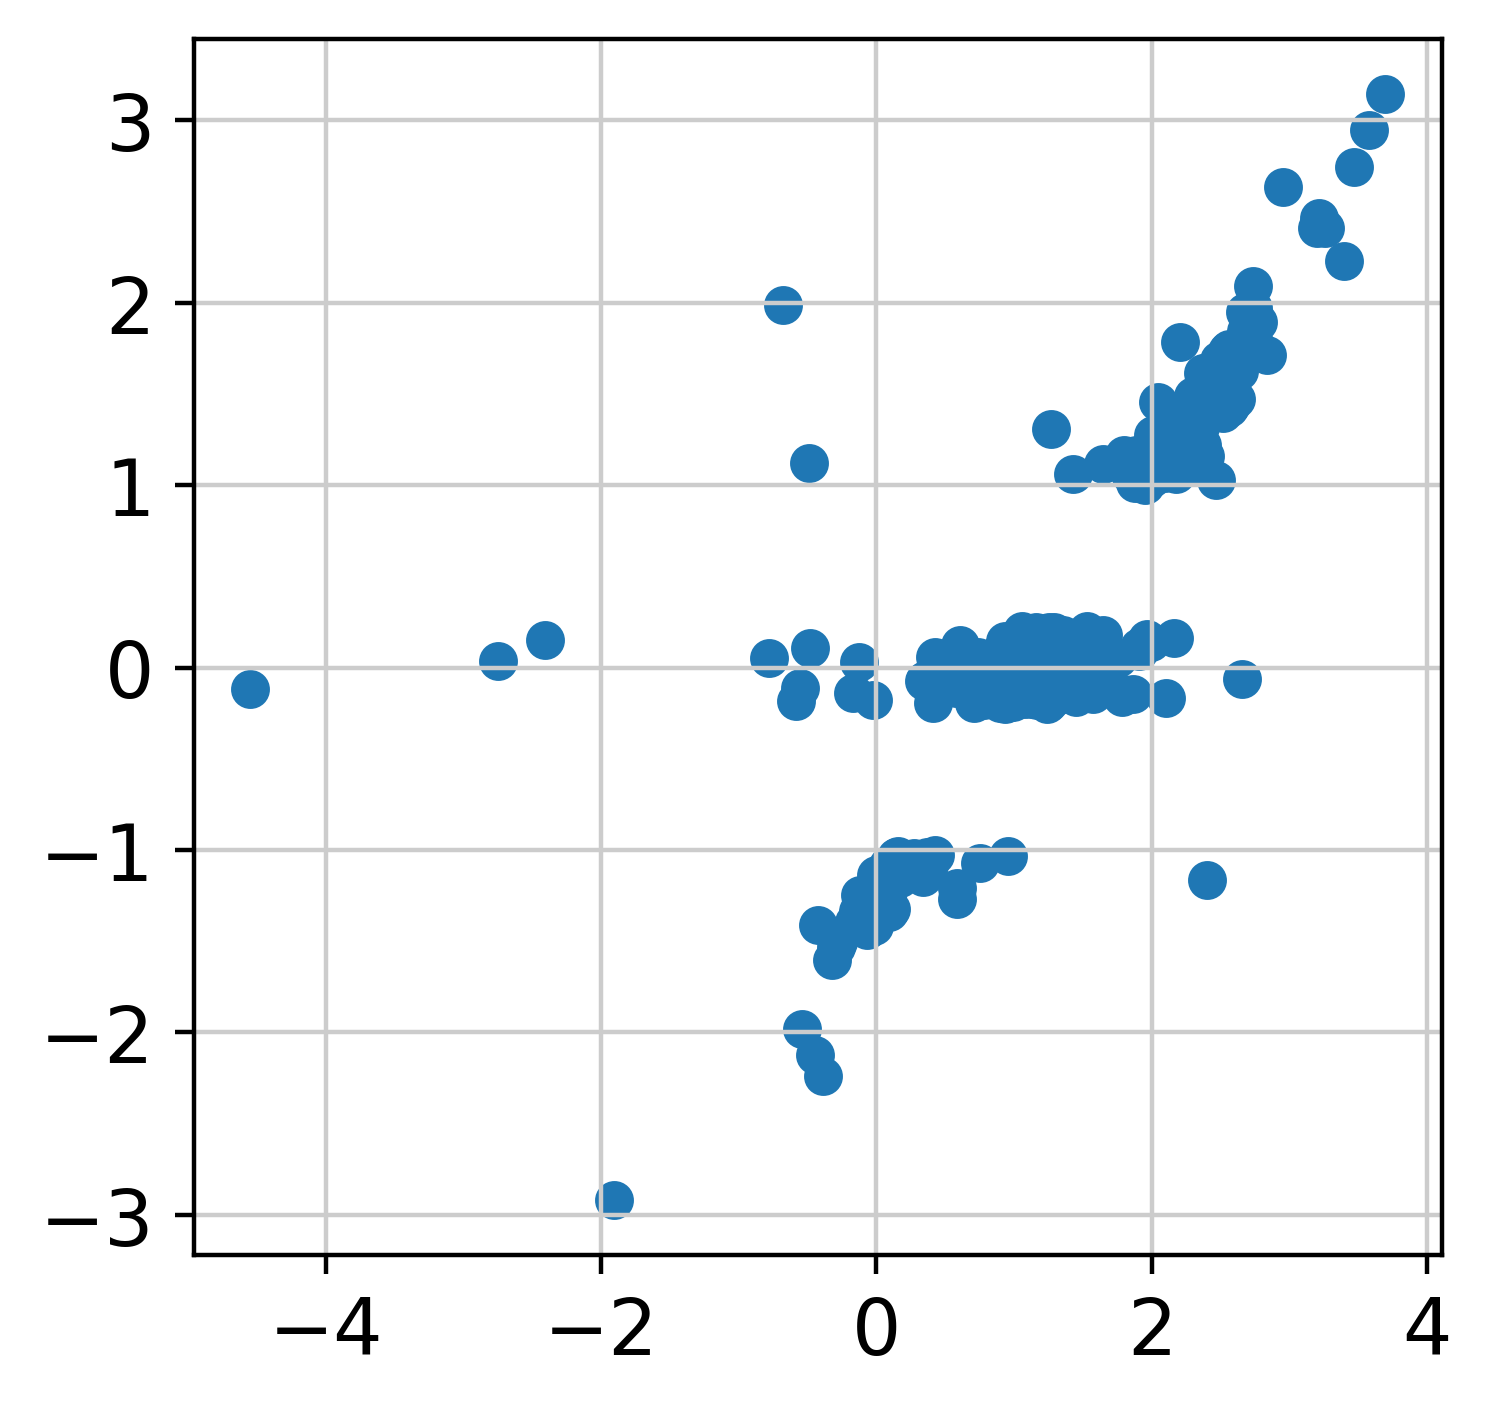

In [38]:
import matplotlib.pyplot as plt
plt.scatter(query_de_df["lfc_median"].values, lfc_info["23"].values)
plt.show()

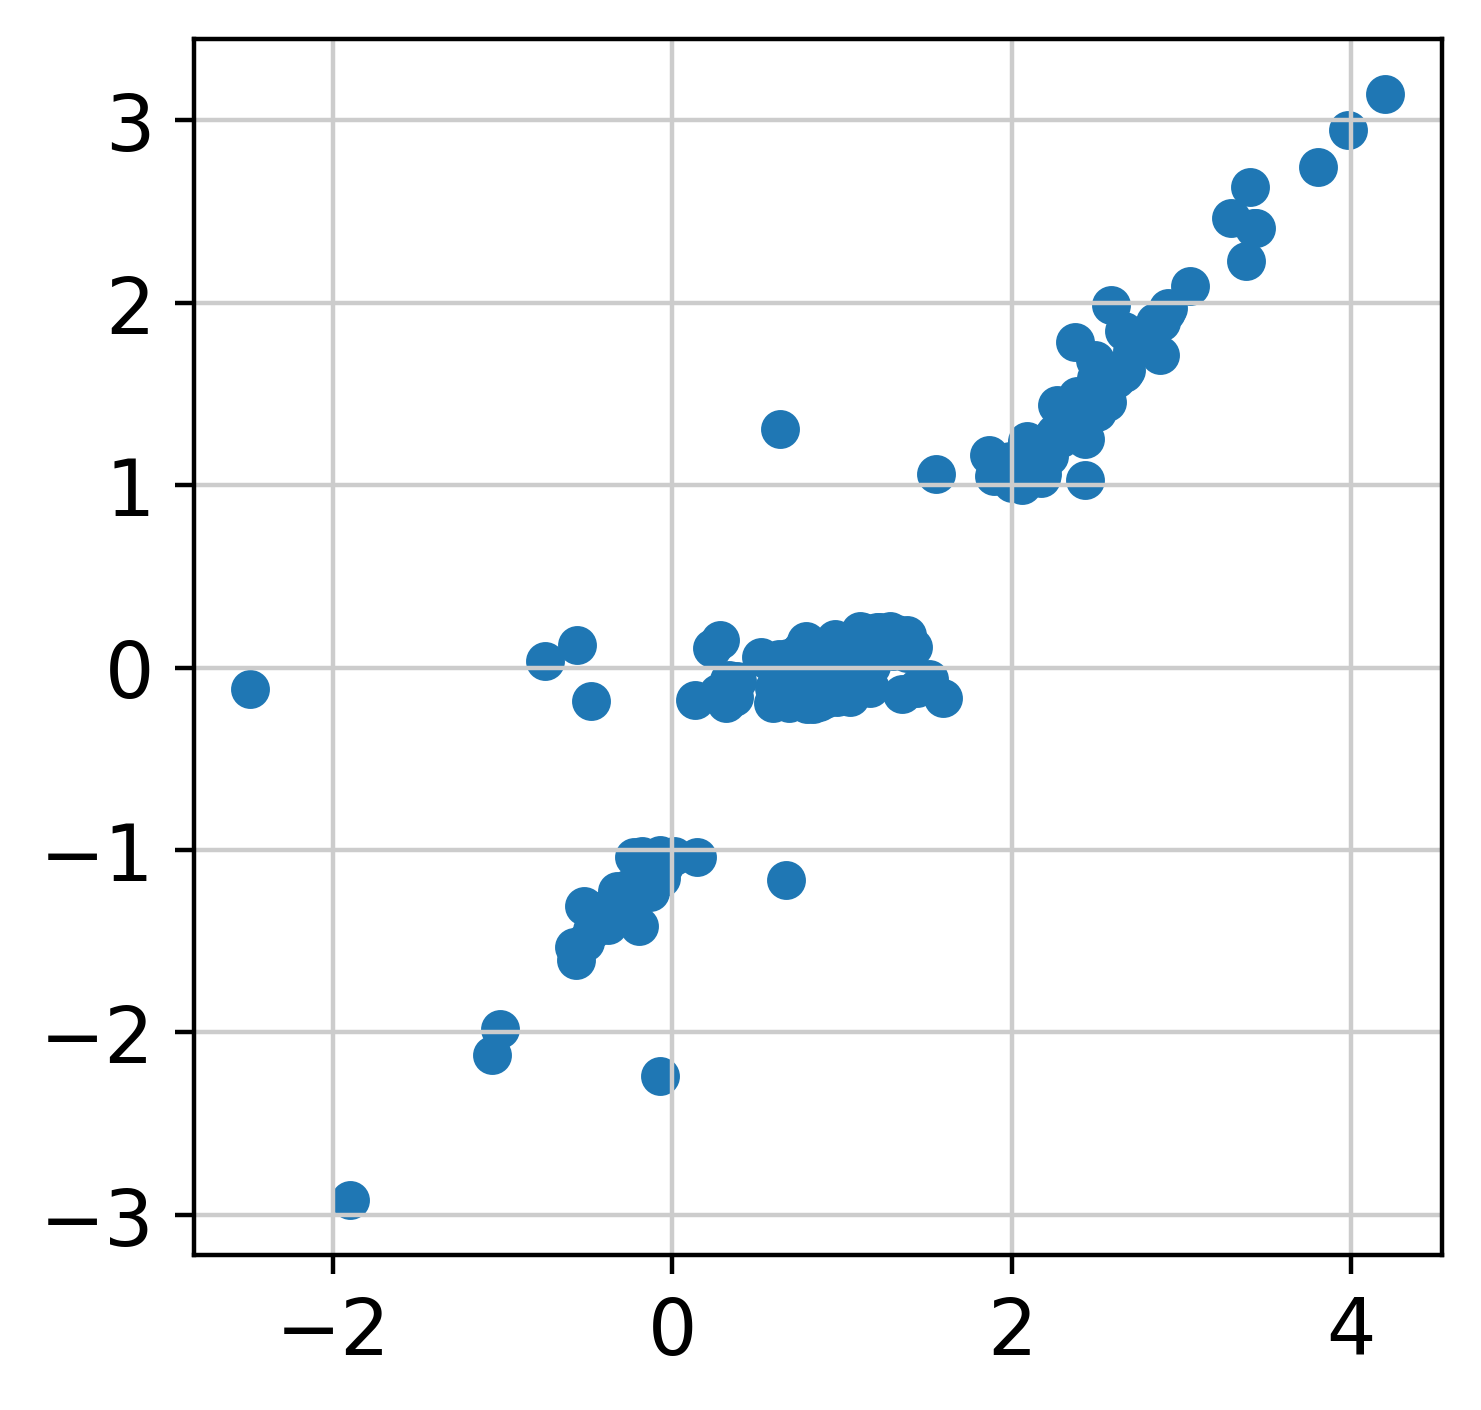

In [39]:
plt.scatter(de_df["lfc_median"].values, lfc_info["23"].values)
plt.show()